In [52]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [53]:
train_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_train.csv')
test_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_test.csv')
val_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_val.csv')
target_col = "default_flag"
SEED = 42

In [54]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(), test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 16) (199, 16) (199, 16)
   failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  default_flag  bnpl_usage_frequency  \
0                               0             0             -0.730258   
1                               0             0              1.319109   
2                               0             0              0.408279   
3                               1             0             -1.641088   
4                               1             0              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                

In [55]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())



X_train shape: (595, 15)    failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  bnpl_usage_frequency  \
0                               0             -0.730258   
1                               0              1.319109   
2                               0              0.408279   
3                               1             -1.641088   
4                               1              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                1.239697                  0.805578   
3                1.594809                 -0.184871

In [56]:
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())

X_test shape: (199, 15)    failed_traditional_credit  external_repayment_loans  \
0                          0                         0   
1                          0                         0   
2                          1                         1   
3                          0                         0   
4                          0                         0   

   credit_card_interest_incidence  bnpl_usage_frequency  \
0                               0              0.180572   
1                               1             -1.413380   
2                               0              1.546817   
3                               0             -1.413380   
4                               0             -0.047135   

   financial_stress_score  credit_limit_utilisation  \
0               -0.890977                  0.005600   
1                1.594809                  1.643651   
2                0.174360                 -1.670546   
3               -0.180752                 -1.327698 

In [57]:
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_val shape: (199, 15)    failed_traditional_credit  external_repayment_loans  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         1   
4                          0                         0   

   credit_card_interest_incidence  bnpl_usage_frequency  \
0                               1             -0.502550   
1                               0              0.408279   
2                               0              0.635987   
3                               0             -0.730258   
4                               1              0.635987   

   financial_stress_score  credit_limit_utilisation  \
0                1.239697                  0.272259   
1               -0.535864                 -1.670546   
2               -0.890977                  0.043694   
3                0.884585                 -0.108683  

In [58]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


default_flag
0    0.922689
1    0.077311
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64
default_flag
0    0.919598
1    0.080402
Name: proportion, dtype: float64


In [59]:
XG_model = XGBClassifier(
    use_label_encoder=False,  # only for XGBoost
    eval_metric="logloss",    # ditto
    random_state=SEED
)


In [60]:
# Fit without early stopping:
XG_model = XGBClassifier(random_state=SEED,
                      use_label_encoder=False,
                      eval_metric="logloss")  

XG_model.fit(X_train, y_train)

# Predict & evaluate:
y_valid_proba = XG_model.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val, y_valid_proba)
print(f"Validation ROC AUC: {auc:.4f}")


Validation ROC AUC: 1.0000


C:\Users\ixz407\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:21:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [61]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators":      [100, 200, 300, 500],
    "max_depth":         [3, 5, 7, 9],
    "learning_rate":     [0.01, 0.05, 0.1, 0.2],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "gamma":             [0, 1, 5],
    "min_child_weight":  [1, 3, 5]
}

rs = RandomizedSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=SEED
    ),
    param_distributions=param_dist,
    n_iter=50,               # number of parameter settings sampled
    scoring="roc_auc",       
    cv=3,                    # 3-fold CV on the training set
    verbose=1,
    n_jobs=-1,
    random_state=SEED
)

rs.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\ixz407\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:21:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [62]:
best_params = rs.best_params_

# Re-instantiate with best params
best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=SEED
)

# Fit on train + valid (optional) or just train
best_model.fit(
    X_train,
    y_train,
    # if your version supports it:
    #early_stopping_rounds=10,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Final AUC on the validation set:
y_valid_proba = best_model.predict_proba(X_val)[:, 1]
from sklearn.metrics import roc_auc_score
print("Tuned model ROC AUC on valid: ",
      roc_auc_score(y_val, y_valid_proba))


C:\Users\ixz407\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:21:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuned model ROC AUC on valid:  1.0


In [63]:
print("Best CV AUC (3-fold on train):", rs.best_score_)
print("Best hyperparameters:", rs.best_params_)


Best CV AUC (3-fold on train): 0.9987401335761992
Best hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


In [64]:
# 1. Predict class labels and probabilities
y_pred      = best_model.predict(X_test)
y_proba_pos = best_model.predict_proba(X_test)[:, 1]

# 2. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
# Optionally, label rows/cols if you want prettier output:
#   tn, fp, fn, tp = cm.ravel()

# 3. Precision, Recall, F1 (binary)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# 4. AUC (just to confirm)
auc = roc_auc_score(y_test, y_proba_pos)
print(f"ROC AUC:   {auc:.3f}")

# 5. Full classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

Confusion matrix:
 [[183   0]
 [  4  12]]
Precision: 1.000
Recall:    0.750
F1-score:  0.857
ROC AUC:   1.000

Classification report:
              precision    recall  f1-score   support

           0      0.979     1.000     0.989       183
           1      1.000     0.750     0.857        16

    accuracy                          0.980       199
   macro avg      0.989     0.875     0.923       199
weighted avg      0.980     0.980     0.979       199



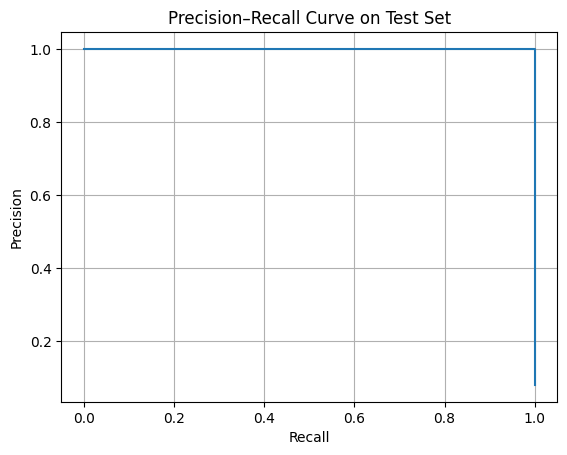

In [65]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_pos)

plt.figure()
plt.plot(recalls, precisions)      # no specific colors
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve on Test Set")
plt.grid(True)
plt.show()


In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def eval_at_thresh(thresh):
    y_pred_thresh = (y_proba_pos >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    prec = precision_score(y_test, y_pred_thresh)
    rec  = recall_score(y_test, y_pred_thresh)
    f1   = f1_score(y_test, y_pred_thresh)
    print(f"Threshold = {thresh:.2f}")
    print(f"  Confusion matrix: [[{tn}, {fp}], [{fn}, {tp}]]")
    print(f"  Precision: {prec:.3f}   Recall: {rec:.3f}   F1: {f1:.3f}\n")

# Example thresholds
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    eval_at_thresh(t)


Threshold = 0.20
  Confusion matrix: [[183, 0], [2, 14]]
  Precision: 1.000   Recall: 0.875   F1: 0.933

Threshold = 0.30
  Confusion matrix: [[183, 0], [3, 13]]
  Precision: 1.000   Recall: 0.812   F1: 0.897

Threshold = 0.40
  Confusion matrix: [[183, 0], [3, 13]]
  Precision: 1.000   Recall: 0.812   F1: 0.897

Threshold = 0.50
  Confusion matrix: [[183, 0], [4, 12]]
  Precision: 1.000   Recall: 0.750   F1: 0.857

Threshold = 0.60
  Confusion matrix: [[183, 0], [4, 12]]
  Precision: 1.000   Recall: 0.750   F1: 0.857



In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_pos)
f1s = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = f1s.argmax()
print("Best F1:", f1s[best_idx], "at thresh =", thresholds[best_idx])
